In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 5]

# System Parameters

In [2]:
g = 9.81 # [m/s2]

# Motor parameters:
rg = 46.85 # Gear ratio
V_rated = 12 # [V]
i_stall = 2.1 # [A]
T_stall = 85 / rg * 0.00706155 # [N-m] (85/rg nominal)
free_run_speed = 160 * rg * np.pi/30 # [rad/s]

k_e = V_rated/free_run_speed # [V/rad/s]
k_t = T_stall/i_stall # [N*m/A]

b = 0.000000 # [N*m/rad/s]
R = V_rated/i_stall # [Ohms]
L = 1e-3 # [H]

# Pendulum parameters:
mp = 1 # Pendulum mass [kg]
mw = 0.3 # Wheel assembly mass [kg]
Ip = 0.01 * 0.00029263 # Pendulum inertia [kg*m^2]
Iw = 0.0026 * 0.00029263 # Wheel assembly inertia [kg*m^2]
l = 0.1 # Length to cg [m]
rw = 0.03 # Wheel radius [m]

# DC Motor System Identification

Define state space for motors.

X = $[\dot{\theta}_{internal}, i]$

Y = $\dot{\theta}_{internal}$ [RPM]

In [3]:
A = np.array([[-b/Iw, k_t/Iw],
              [-k_e/L, -R/L]])
B = np.array([[0],[1/L]])
C = np.array([30/np.pi/rg, 0]) 
D = np.array(0)

motor_ss = control.ss(A,B,C,D)
motor_tf = control.tf(motor_ss)
motor_tf


        1.634e+06
------------------------
s^2 + 5714 s + 1.226e+05

Test step to motor, and plot experimental data.

159.999999929


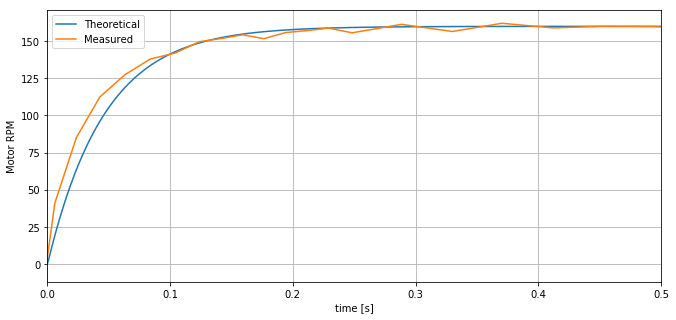

In [12]:
time = []
pos = []
f = open('rpm_data.txt')
for line in f.readlines():
    dat = line.split(',')
    time.append(float(dat[0]))
    pos.append(int(dat[1][:-1]))

num_skip = 100
time = np.array(time)[::num_skip]
pos = np.array(pos)[::num_skip]
rpm = np.diff(pos)/(46.85*48)/np.diff(time)*60

(t, y_out) = control.step_response(motor_tf, np.linspace(0,1,1000))
V = 12 # Applied step voltage
omega_rpm = V * y_out
print(np.max(omega_rpm))

plt.clf()
plt.plot(t,omega_rpm)
plt.plot(time[:-1]-1,-rpm)
plt.xlim((0,0.5))
#plt.title("Motor RPM")
plt.xlabel('time [s]')
plt.ylabel('Motor RPM')
plt.legend(['Theoretical','Measured'])
plt.grid(True)
plt.show()

In [ ]:
T = 0.0021

Kp = 0.1
Kd = 0
Ki = 0

#PID = control.tf([1],[1,1])
PID = control.tf([Kd+Kp+Ki,-Kd],[1,-1],T)
print(PID)
motor_tf_d = control.c2d(motor_tf,T)

#motor_sys = PID_d*motor_tf_d/(1+PID_d*motor_tf_d) 
motor_sys = control.feedback(PID*motor_tf_d)
print(motor_sys)
#t = np.arange(1,10,1)
#t,sys_out = control.step_response(motor_sys)

plt.clf()
plt.plot(t*T,sys_out[0][0:len(t)],label='system')
#plt.xlim((0,2))
plt.title("RPM")
plt.xlabel('time [s]')
plt.ylabel('RPM')
plt.legend()
plt.grid(True)
plt.show()

# Full System Simulation

X = $[x, \dot{x}, \theta, \dot{\theta}]$

u = Voltage

In [ ]:
M = np.array([[1, 0, 0, 0],
              [0, mp+mw+Ip/(rw**2), 0, mp*l],
              [0, 0, 1, 0],
              [0, mp*l, 0, Ip+mp*(l**2)]])
M_inv = np.linalg.inv(M)

a = np.array([[0, 1, 0, 0],
              [0, -2*k_t*k_e/(R*rw*rw), 0, -2*k_t*k_e/(R*rw)],
              [0, 0, 0, 1],
              [0, 2*k_t*k_e/(R*rw), mp*g*l, 2*k_t*k_e/R]])
b = np.array([[0],
              [2*k_t/(R*rw)],
              [0],
              [-2*k_t/R]])
A = M_inv @ a
B = M_inv @ b
C = np.eye(4)
C = np.array([0,0,1,0])
D = np.zeros([1,1])
print(A)
print(D)

In [ ]:
sys_ss = control.ss(A,B,C,D)
sys_tf = control.tf(sys_ss)
control.bode(sys_tf)
plt.show()
control.dcgain(sys_tf)

Calculate LQR:

In [ ]:
Q = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
R = np.array([1])
K,_,_ = control.lqr(A,B,Q,R)
K